In [4]:
import numpy as np

In [5]:
# Do set your runtime to GPU. You will need it
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable
from torchvision.io import read_image
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from os.path import join
import matplotlib.pyplot as plt

In [2]:
torch.autograd.set_detect_anomaly(True)

In [3]:
UPSCALE_FACTOR = 1
CROP_SIZE = 80

In [4]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [5]:
# Now, I will load in some code for the dataset and dataloaders.
# Link to this notebook will be in the description, so you can get it from there
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])


class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [15]:
class createDataset(Dataset):
    def __init__(self,dataset_dir,data_type):
        super(Dataset, self).__init__()
        self.image_filenames = listdir(f"./{dataset_dir}/{data_type}_HR")
        self.path_HR = f"./{dataset_dir}/{data_type}_HR"
        self.path_LR = f"./{dataset_dir}/{data_type}_LR"
    
    def __getitem__(self, index):
        image_filename = self.image_filenames[index]
        image_HR = read_image(join(self.path_HR,image_filename))
        image_HR = image_HR.type(torch.float)
        image_LR = read_image(join(self.path_LR,image_filename))
        image_LR = image_LR.type(torch.float)
        return image_LR,image_HR
    
    def __len__(self):
        return len(self.image_filenames)

In [16]:
train_set = createDataset("srgan_dataset","train")
trainloader = DataLoader(train_set,batch_size=16,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 640, 640]) torch.Size([16, 3, 640, 640])


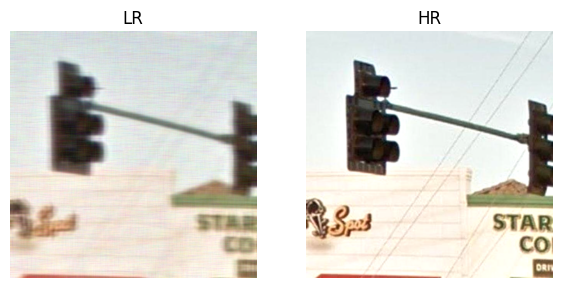

In [19]:
lrimages,hrimages = next(iter(trainloader))
print(lrimages.size(),hrimages.size())
n = np.random.randint(0,16)

fig,axes = plt.subplots(1,2,figsize=(7,14))
axes[0].imshow(lrimages[n].squeeze().permute(1,2,0)/225)
axes[1].imshow(hrimages[n].squeeze().permute(1,2,0)/225)
axes[0].axis("off")
axes[0].set_title("LR")
axes[1].axis("off")
axes[1].set_title("HR")
plt.show()

In [21]:
lrimage = lrimages[n].squeeze().permute(1,2,0)
# torch.tensor(lrimage)
# lrimage.type(torch.float)
lrimage

tensor([[[190., 207., 199.],
         [188., 205., 197.],
         [190., 207., 199.],
         ...,
         [185., 196., 192.],
         [189., 193., 192.],
         [186., 188., 187.]],

        [[182., 197., 192.],
         [179., 196., 190.],
         [181., 196., 191.],
         ...,
         [180., 190., 189.],
         [183., 189., 189.],
         [177., 181., 182.]],

        [[193., 205., 203.],
         [189., 204., 201.],
         [193., 205., 203.],
         ...,
         [182., 196., 197.],
         [187., 194., 200.],
         [183., 188., 194.]],

        ...,

        [[223., 207., 210.],
         [219., 204., 207.],
         [219., 209., 210.],
         ...,
         [120., 114.,  78.],
         [120., 114.,  80.],
         [119., 113.,  79.]],

        [[223., 207., 217.],
         [219., 206., 215.],
         [219., 209., 217.],
         ...,
         [124., 114.,  78.],
         [125., 115.,  80.],
         [123., 113.,  78.]],

        [[218., 205., 215.],
       

In [22]:
from torch import nn, optim

In [23]:
# Now we will start implementing the model. We will start in this vid, and co,plee
# in the next video
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)
  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual

# We just implemented a pretty standard residual block here

In [24]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

In [25]:
class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    upsample_block_num = int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)
    self.block4 = ResidualBlock(64)
    self.block5 = ResidualBlock(64)
    self.block6 = ResidualBlock(64)
    self.block7 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
    block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block8 = nn.Sequential(*block8)
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    block8 = self.block8(block1 + block7)
    return (torch.tanh(block8) + 1) / 2

In [26]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)
    )
  def forward(self, x):
    batch_size=x.size()[0]
    return torch.sigmoid(self.net(x).view(batch_size))

In [6]:
# from torchvision.models.vgg import vgg16
from ultralytics import YOLO

In [7]:
yolo_model = YOLO("D:/academic/Internship/CWNU/Actual/yolov5/runs/train/yolov5s_results/weights/best.pt")

In [8]:
yolo_model

YOLO(
  (model): Model(
    (model): Sequential(
      (0): Focus(
        (conv): Conv(
          (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): BottleneckCSP(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (cv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias

In [30]:
# Now we got to make the Generator Loss
class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])

    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  # Forgot to implement an important method
  @staticmethod # Must add this
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]

In [31]:
from models.yolo import Model

class YOLOv5FeatureExtractor(Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # self.load_state_dict()
        
    def load_another(self,inspo):
        self.model.load_state_dict(inspo)

    def forward(self, x):
        # Pass through layers upto the point you need (as an example, layer 3)
        x = self.model[0:9](x)
        return x

# Load your model
feature_extractor = YOLOv5FeatureExtractor('D:/academic/Internship/CWNU/Actual/yolov5/models/custom_yolov5s.yaml')
len(feature_extractor.model)

# img = torch.randn(5, 3, 640, 640)  # Example input
# features = feature_extractor(img)
# print(features.shape)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     19904  models.common.BottleneckCSP             [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  3    161152  models.common.BottleneckCSP             [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              


  6                -1  3    641792  models.common.BottleneckCSP             [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  1    656896  models.common.SPP                       [512, 512, [5, 9, 13]]        
  9                -1  1   1248768  models.common.BottleneckCSP             [512, 512, 1, False]          
 10                -1  1    131584  models.common.Conv                      [512, 256, 1, 1]              
 11                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 12           [-1, 6]  1         0  models.common.Concat                    [1]                           
 13                -1  1    378624  models.common.BottleneckCSP             [512, 256, 1, False]          
 14                -1  1     33024  models.common.Conv                      [256, 128, 1, 1]              
 15                -1  1         0  t

25

In [32]:
ymd = yolo_model.state_dict()
new_ymd = dict()

for k,v in ymd.items():
    new_ymd[k[12:]] = v

In [34]:
new_ymk = list(new_ymd.keys())
fek = list(feature_extractor.state_dict().keys())

counter=0

for i in range(len(new_ymk)):
    # print("model.",new_ymk[i]," - ",fek[i])
    if("model."+new_ymk[i]==fek[i]):
        counter+=1

counter

369

In [35]:
feature_extractor.load_another(new_ymd)

In [36]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    # vgg = vgg16(pretrained=True)
    # loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
    loss_network = feature_extractor
    for param in loss_network.parameters():
      param.requires_grad = False
    self.loss_network = loss_network
    self.mse_loss = nn.MSELoss()
    self.tv_loss = TVLoss()
  def forward(self, out_labels, out_images, target_images):
    adversial_loss = torch.mean(1 - out_labels)
    perception_loss = self.mse_loss(out_images, target_images)
    image_loss = self.mse_loss(out_images, target_images)
    tv_loss = self.tv_loss(out_images)
    return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


In [46]:
device  = torch.device("cpu")
# device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Standard device selectoin
device

device(type='cpu')

In [47]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [48]:
generator_criterion = GeneratorLoss()

In [49]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [50]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [51]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

In [52]:
## Now for training code
from tqdm import tqdm
import os

In [53]:
N_EPOCHS = 10 # 150 is good enough for our model. gives decent enough results

In [54]:
for epoch in range(1, N_EPOCHS + 1):
  train_bar = tqdm(trainloader)
  running_results = {'batch_sizes':0, 'd_loss':0,
                     "g_loss":0, "d_score":0, "g_score":0}

  netG.train()
  netD.train()
  for data, target in train_bar:
    g_update_first = True
    batch_size = data.size(0)
    running_results['batch_sizes'] += batch_size

    real_img = Variable(target)
    real_img = real_img.to(device)
    z = Variable(data)
    z = z.to(device)

    ## Update Discriminator ##
    fake_img = netG(z)
    netD.zero_grad()
    real_out = netD(real_img).mean()
    fake_out = netD(fake_img).mean()
    d_loss = 1 - real_out + fake_out
    d_loss.backward(retain_graph = True)
    optimizerD.step()

    ## Now update Generator
    fake_img = netG(z)
    fake_out = netD(fake_img).mean()
    netG.zero_grad()
    g_loss = generator_criterion(fake_out, fake_img, real_img)
    g_loss.backward()

    fake_img = netG(z)
    fake_out = netD(fake_img).mean()

    optimizerG.step()

    running_results['g_loss'] += g_loss.item() * batch_size
    running_results['d_loss'] += d_loss.item() * batch_size
    running_results['d_score'] += real_out.item() * batch_size
    running_results['g_score'] += real_out.item() * batch_size

    ## Updating the progress bar
    train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
        epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
        running_results['g_loss'] / running_results['batch_sizes'],
        running_results['d_score'] / running_results['batch_sizes'],
        running_results['g_score'] / running_results['batch_sizes']
    ))
  netG.eval()

  0%|          | 0/31 [00:00<?, ?it/s]Exception ignored in: <generator object tqdm.__iter__ at 0x00000173A883D150>
Traceback (most recent call last):
  File "d:\computers\Python\Environments\Pytorch cuda env\.venv\lib\site-packages\tqdm\std.py", line 1182, in __iter__
    yield obj
KeyboardInterrupt: 


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1677721600 bytes.

In [ ]:
# We will just make sure that this model trains 5 epochs successfuly
# This will take around 2 hours to train, please monitor colab
# To make sure that it does not time out
# There might be few errors, mostly due to typos
# The progress bar acts slightly weird
# But you see the model is now training
